1. История Н. Кодера и Д. Кодера
2. Автоэнкодер на MNIST
3. Рисуем скрытое пространство
4. Сгенерим из пространства изображение
5. VAE и его скрытое пространство
6. Операции с латентными векторами

In [ ]:
from IPython.display import Image
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import numpy as np
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [265]:
get_encoder_block = lambda dim_from, dim_to: nn.Sequential(
                    nn.Conv2d(dim_from, out_channels=dim_to,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(dim_to),
                    nn.LeakyReLU())

get_decoder_block = lambda dim_from, dim_to: nn.Sequential(
                    nn.ConvTranspose2d(dim_from,
                                       dim_to,
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(dim_to),
                    nn.LeakyReLU())

In [346]:
SMALLEST_FEATURE_W = 4

In [347]:
class Encoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(Encoder, self).__init__()
        self.encoder_dims = hidden_dims
        self.encoder = nn.Sequential(*[get_encoder_block(self.encoder_dims[i], self.encoder_dims[i+1]) for i in range(len(self.encoder_dims) - 1)]) # 
        self.linear1 = nn.Linear(SMALLEST_FEATURE_W*SMALLEST_FEATURE_W*self.encoder_dims[-1], latent_dims)
    
    def forward(self, inputs):
        x = self.encoder(inputs)
        x = self.linear1(x.view(x.shape[0], -1))
        return x

In [392]:
class Decoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(Decoder, self).__init__()
        self.decoder_dims = hidden_dims
        self.linear2 = nn.Linear(latent_dims, SMALLEST_FEATURE_W*SMALLEST_FEATURE_W*self.decoder_dims[0])
        self.decoder = nn.Sequential(*[get_decoder_block(self.decoder_dims[i], self.decoder_dims[i+1]) for i in range(len(self.decoder_dims) - 2)])
        self.final = nn.Sequential(*[
            nn.Conv2d(in_channels=hidden_dims[-2], out_channels=1, kernel_size=1),
            nn.Sigmoid()
        ])
    
    def forward(self, inputs):
        x = self.linear2(inputs)
        x = self.decoder(x.view(x.shape[0], self.decoder_dims[0], 4, 4))
        x = self.final(x)
        return x

In [393]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.hidden_dims = [1, 16, 32, 64, 128]
        self.encoder = Encoder(hidden_dims=self.hidden_dims, latent_dims=latent_dims)
        self.decoder = Decoder(hidden_dims=self.hidden_dims[::-1], latent_dims=latent_dims)



    def forward(self, inputs):
       x = self.encoder(inputs)
       return self.decoder(x)
       


In [394]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [395]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
              transform=torchvision.transforms.Compose([
                     torchvision.transforms.Pad(2),
                     torchvision.transforms.ToTensor()
              ]),
              download=True),
        batch_size=128,
        shuffle=True)

In [396]:
autoencoder_10 = train(autoencoder, data, epochs=10) 

100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


In [401]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 32
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(32, 32).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [402]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

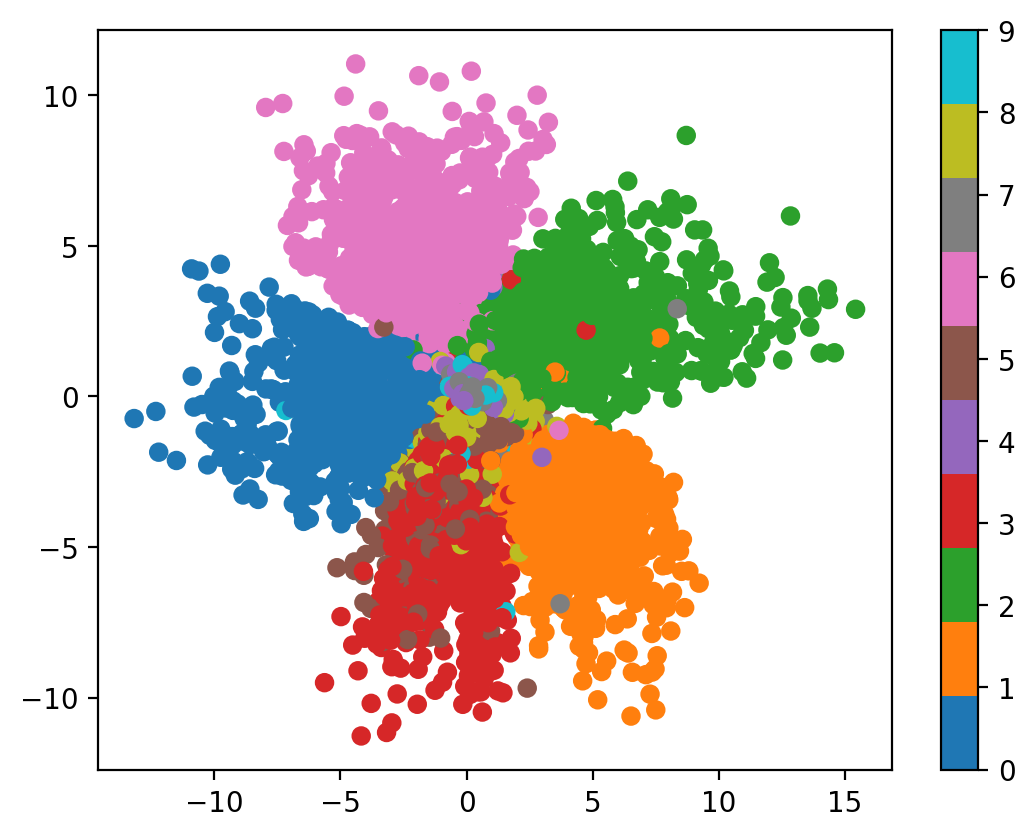

In [403]:
plot_latent(autoencoder_10, data)

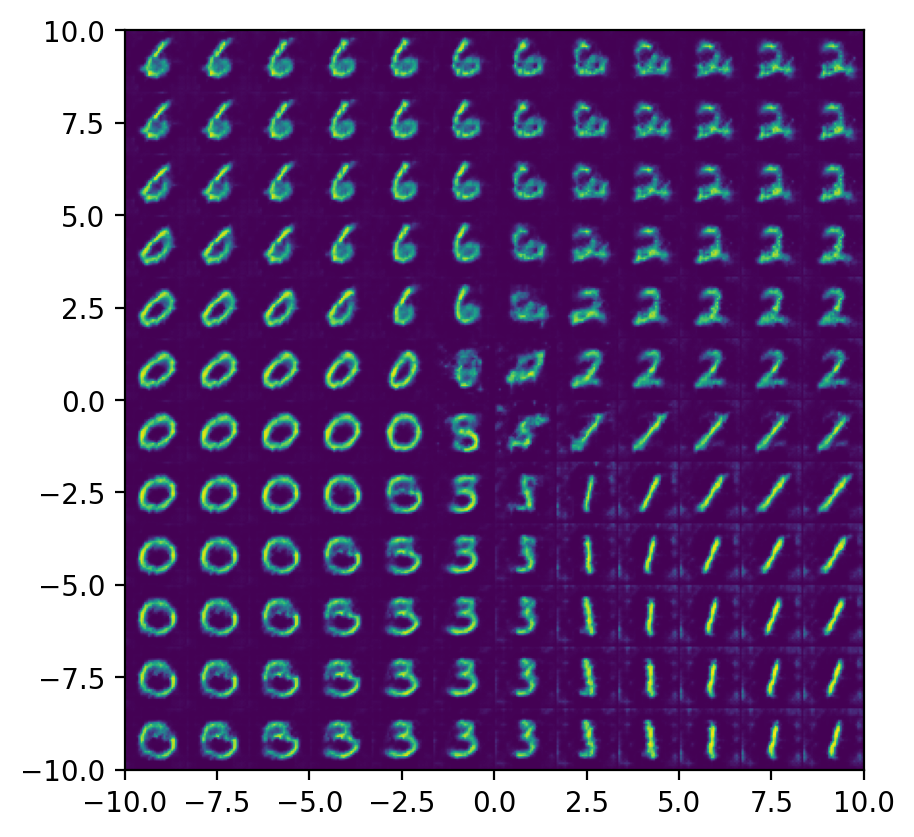

In [404]:
plot_reconstructed(autoencoder_10, r0=(-10, 10), r1=(-10, 10))

In [418]:
class VariationalEncoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.encoder_dims = hidden_dims
        self.encoder = nn.Sequential(*[get_encoder_block(self.encoder_dims[i], self.encoder_dims[i+1]) for i in range(len(self.encoder_dims) - 1)]) # 
        self.sigma = nn.Linear(SMALLEST_FEATURE_W*SMALLEST_FEATURE_W*self.encoder_dims[-1], latent_dims)
        self.mu = nn.Linear(SMALLEST_FEATURE_W*SMALLEST_FEATURE_W*self.encoder_dims[-1], latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, inputs):
        x = self.encoder(inputs)
        sigma = self.sigma(x.view(x.shape[0], -1))
        mu =  self.mu(x.view(x.shape[0], -1))
        sigma = torch.exp(sigma)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [419]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.hidden_dims = [1, 16, 32, 64, 128]
        self.encoder = VariationalEncoder( self.hidden_dims, latent_dims,)
        self.decoder = Decoder(self.hidden_dims[::-1], latent_dims, )

    def forward(self, x):
        z = self.encoder(x)
        z = self.decoder(z)
        return z

In [424]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward() 
            opt.step()
    return autoencoder

In [425]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data, epochs=10)

100%|██████████| 10/10 [01:54<00:00, 11.43s/it]


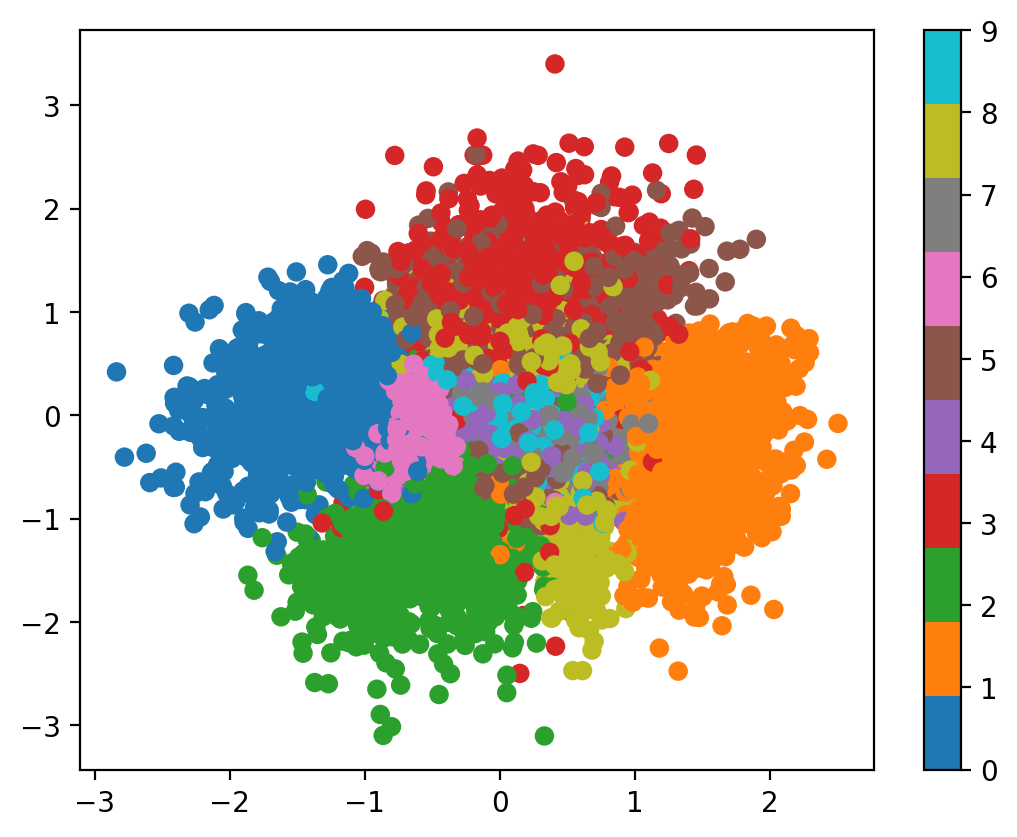

In [426]:
plot_latent(vae, data)

In [433]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 32
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(32, 32)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [436]:
x, y = next(iter(data)) # hack to grab a batch
x_1 = x[y == 0][0].to(device).unsqueeze(0) # find a 1
x_2 = x[y == 5][6].to(device).unsqueeze(0) # find a 0

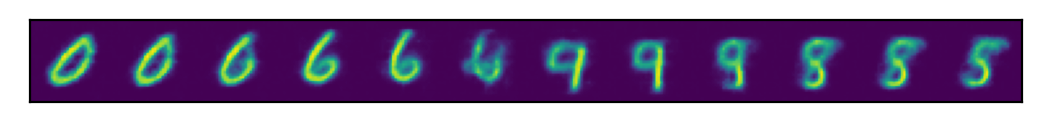

In [437]:
interpolate(vae, x_1, x_2, n=12)

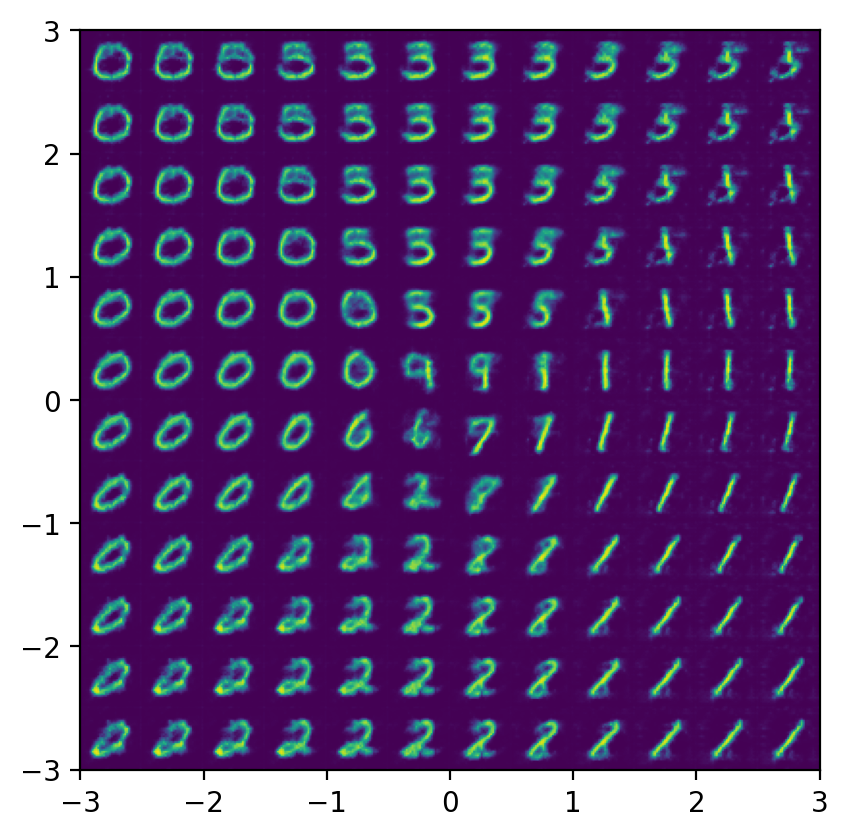

In [438]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))